# Overview 
In this assignment you will implement a two-layer neural network. You will implement the loss functions, gradients, optimizers to train the network and test its performance on MNIST dataset. 

For this assignment we will use the functionality of Pandas (https://pandas.pydata.org/), Matplotlib (https://matplotlib.org/), and Numpy (http://www.numpy.org/). 

If you are asked to **implement** a particular functionality, you should **not** use an existing implementation from the libraries above (or some other library that you may find). When in doubt, please ask. 

Before you start, make sure you have installed all those packages in your local Jupyter instance

## Read *all* cells carefully and answer all parts (both text and missing code)

You will complete all the code marked `TODO` and answer descriptive/derivation questions 



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

### Load MNIST Dataset 

For this assignment, we will use [MNIST](https://en.wikipedia.org/wiki/MNIST_database) handwritten digits data set. The dataset consists 10 handwritten digits (0,1,...,9). It is a widely used dataset to demonstrate simple image classification problem.

MNIST dataset is publicly available from different sources. We will be using MNIST from Keras package. If you do not have Keras installed, you can find the installation guide [here](https://www.tutorialspoint.com/keras/keras_installation.htm). 

In short, you need to run ```conda install -c anaconda keras``` or ```pip install keras```

The training data consists of 60000 images of size $28 \times 28$ pixels; the test data consists of 10000 images.

Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)


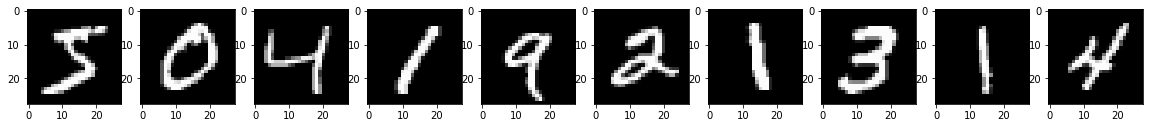

In [2]:
# Load MINST Dataset
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('Training data shape:', x_train.shape)
print('Test data shape:', x_test.shape)

# Plot MINST Examples
n_img = 10
plt.figure(figsize = (n_img * 2, 2))
plt.gray()
for i in range(n_img):
    plt.subplot(1, n_img, i + 1)
    plt.imshow(x_train[i])
plt.show()

We will be vectorizing the training and test images. So, the size of each vector will be 784.

In [3]:
# Reshape data 
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

print('Training data shape after reshaping:', x_train.shape)
print('Test data shape after reshaping::', x_test.shape)

Training data shape after reshaping: (60000, 784)
Test data shape after reshaping:: (10000, 784)


## Question 1: Binary classification using neural network

We will start with classification of images for two different digits using a two-layer network with a cross entropy loss. 

In the next question, we will extend the same architecture to multi-class classification. 

Pick any two digits out of ten for our classification (say 5 and 8), which we will assign label "0" or "1". 

Pick same number of images from each class for training and create arrays for input and output (say 1000). 

```
# train_x -- N x 784 array of training input
# train_y -- N x 1 array of binary labels 
```  

If you use 1000 images from each class N = 2000. You can increase the number of training samples if you like. It is just a suggestion. 


We also need to transpose the dimension of the data so that their size becomes $784\times N$. It will be helpful to feed it to our model based on our notations.


In [4]:
"""Make a subset dataset from MNIST, containing only 2 classes for binary classification task 
    Args:
        x (numpy.ndarray): data, can be x_train or x_test
        y (numpy.ndarray): labels of data, can be y_train or y_test
        label1 (int): the first class you pick, e.g. 5
        label2 (int): the second class you pick, e.g. 8
        num_samples (int): the number of images you select for each class, e.g. 1000
    Returns:
        x_ (numpy.ndarray): the data for 2 picked classes
        y_ (numpy.ndarray): the corresponding labels for 2 picked classes
"""
def extract_binary_classification_dataset(x, y, label1, label2, num_samples):
    # Numpy array for class 1
    x1 = x[y == label1]
    x1 = x1[:num_samples]
    y1 = np.zeros(len(x1)) # 0 = Class 1

    # Numpy array for class 2
    x2 = x[y == label2]
    x2 = x2[:num_samples]
    y2 = np.ones(len(x2)) # 1 = Class 2

    # Combine 2 classes
    x_ = np.concatenate((x1, x2), axis = 0)
    y_ = np.concatenate((y1, y2), axis = 0)
    return x_.T, y_

# Pick your own digits
label1 = 5
label2 = 8
num_samples = 1000

# Train & test data
train_x, train_y = extract_binary_classification_dataset(x_train, y_train, label1, label2, num_samples)
test_x, test_y = extract_binary_classification_dataset(x_test, y_test, label1, label2, num_samples)

### Network Architecture

We will be using a two layer neural network in our experiment. The input layer will have 784 nodes, the hidden layer will have 256 nodes and the output layer will have 1 node. Each node will have $\textit{sigmoid}$ activation function.

The equations for feedforward operation will be the following:

$$\mathbf{z}^{(1)}=W^{(1)} \mathbf{x}+ \mathbf{b}^{(1)}\\\mathbf{y}^{(1)}=\varphi(\mathbf{z}^{(1)})\\\mathbf{z}^{(2)}=W^{(2)}  \mathbf{y}^{(1)}+ \mathbf{b}^{(2)} \\\mathbf{y}^{(2)}=\varphi(\mathbf{z}^{(2)})$$

where $\mathbf{x}\in \mathbb{R}^{784}$ is the input layer, $\mathbf{y}^{(1)}\in \mathbb{R}^{256}$ is the hidden layer, $\mathbf{y}^{(2)} \in \mathbb{R}$ is the output layer, $W^{(1)}\in \mathbb{R}^{256\times 784}$ is the first layer weights, $W^{(2)}\in \mathbb{R}^{1\times 256}$ is the second layer weights, $\mathbf{b}^{(1)}\in \mathbb{R}^{256}$ is the first layer bias, $\mathbf{b}^{(2)}\in \mathbb{R}$ is the second layer bias, $\varphi(\cdot)$ is the activation function.

### Network initialization

We initialize the weights for $W^{(1)}$ and $W^{(2)}$ with random values drawn from normal distribution with zero mean and 0.01 standard deviation. We will initialize bias vectors $\mathbf{b}^{(1)}$ and $\mathbf{b^{(2)}}$ with zero values. 

We can fix the seed for random initialization for reproducibility.

In [5]:
# Initialize Nueral Network
def TwoLayerNetwork(layer_dims=[784, 256, 1]):
    # Fix the seed
    np.random.seed(3)

    # Initialize Normally Distributed Weights
    W1 = np.random.normal(0, 0.01, (layer_dims[1], layer_dims[0])) # (256, 784)
    W2 = np.random.normal(0, 0.01, (layer_dims[2], layer_dims[1])) # (1, 256)

    # Initialize Biases to 0
    b1 = np.zeros(layer_dims[1]) # (256, )
    b2 = np.zeros(layer_dims[2]) # Scalar

    # Return array of weights/biases
    params = np.array([W1, b1, W2, b2], dtype=object)
    return params

### Sigmoid activation function 
Now we will write the sigmoid activation function as 

$$ \varphi(z) = \frac{1}{1+e^{-z}}$$

Note that derivative of __sigmoid__ is $\varphi'(z) = \varphi(z) (1-\varphi(z))$. 

In [6]:
# Sigmoid Function
def sigmoid(Z):
    # Input: Z numpy.ndarray
    Y = 1/(1 + np.exp(-Z))
    return Y

### Cross entropy loss function
We will minimize the binary cross entropy loss function. You will use the true labels and predicted labels of a batch of N samples. 

Binary crossentropy loss for $i^{th}$ sample can be written as 

$$Loss_i = -y_i \log y^{(2)}_i- (1-y_i) \log (1-y^{(2)}_i)$$

where $y_i$ is the true label. We can find the average loss for a batch of N samples as $Loss=\frac{1}{N}\sum_{i=1}^{N} Loss_i$.

Note that the gradient of the cross entropy loss w.r.t. the output is 

$$ \nabla_{y^{(2)}} Loss_i = -\frac{y_i}{y_i^{(2)}} + \frac{1-y_i}{1-y_i^{(2)}} = \frac{y_i^{(2)}-y_i}{y_i^{(2)}(1-y_i^{(2)})}.$$

We can also show that $$\delta^{(2)} = \nabla_{\mathbf{z}^{(2)}} Loss_i  = \nabla_{y^{(2)}} Loss_i \odot \varphi'(\mathbf{z})= y_i^{(2)}-y_i,$$ 
where $\odot$ denotes element-wise multiplication of the arrays. 

In [7]:
# Cross Entropy Loss Function
def CrossEntropyLoss(Y_true, Y2):
    # Num samples
    N = np.size(Y_true)

    # Average Loss of All Samples
    loss = 0
    for i in range(N):
      loss += (1/N) * (-Y_true[i] * math.log(Y2[i])) - ((1 - Y_true[i]) * (math.log(1 - Y2[i])))
    return loss

### Forward propagation
Next, we will write the code for the forward pass for two layer network. Each layer consists of an affine function (fully-connected layer) followed by an activation function. You wil also return the intermediate results ($\mathbf{x}, \mathbf{z}^{(1)}, \mathbf{y}^{(1)}, \mathbf{z}^{(2)}$) in addition to final output ($\mathbf{y}^{(2)}$). You will need the intermediate outputs for the backpropagation step.

In [8]:
# Forward Propagation Function
def forward(X, params):
    # Inputs:
      # X -- 784 x N array 
      # params
        # W1 -- 256 x 784 matrix
        # b1 -- 256 x 1 vector
        # W2 -- 1 x 256 matrix
        # b2 -- 1 x 1 scalar 
      
    # Outputs:
      # Y2 -- 1 x N output
    
    N = np.size(X)/784 # Num samples

    Z1 = np.matmul(params[0], X) + params[1][:, np.newaxis] # W1X + b1
    Y1 = sigmoid(Z1) # Output of layer 1
    Z2 = np.matmul(params[2], Y1) + params[3][:, np.newaxis] # W2Y1 + b2
    Y2 = sigmoid(Z2) # Final output
    Y2 = Y2.flatten() # Make 1D

    # Put all intermediate values in array and return
    intermediate = np.array([X, Z1, Y1, Z2], dtype=object)
    return Y2, intermediate

### Backpropagration step
Now we will implement the backpropagation step for the two layer neural network. 

You will need the gradient of the Loss w.r.t. $W^{(l)},\mathbf{b}^{(l)}$ for $l = 1,2$ for all the training samples.  



We saw that we can write the gradient of Loss with respect to $W^{(l)}, \mathbf{b}^{(l)}$ for a single sample as

$$\nabla_{W^{(l)}} Loss_i = \delta^{(l)} \mathbf{y}^{(l-1)T},$$  
$$\nabla_{\mathbf{b}^{(l)}} Loss_i = \delta^{(l)},$$

where 
$$\delta^{(l)} = \nabla_{\mathbf{z}^{(l)}} Loss_i = \nabla_{\mathbf{y}^{(l)}} Loss_i \odot \varphi'(\mathbf{z}^{(l)}).$$ 


For the the last layer, we can compute $\delta^{(L)}$ by plugging the value of $\nabla_{\mathbf{y}^{(L)}} Loss$ as described above. 

For the intermediate layers $l<L$, we can write 
$$\delta^{(l)} = W^{(l+1)T}\delta^{(l+1)} \odot \varphi'(\mathbf{z}^{(l)}).$$ 



**Once we have the gradients $\nabla_{W^{(l)}} Loss_i, \nabla_{\mathbf{b}^{(l)}} Loss_i$ for all $i$. We can compute their average to compute the gradient of the total loss function $\frac{1}{N} \sum_{i=1}^N Loss_i$ as**

$$\nabla_{W^{(l)}} Loss = \frac{1}{N} \sum_i \nabla_{W^{(l)}} Loss_i, $$
$$ \nabla_{\mathbf{b}^{(l)}} Loss = \frac{1}{N} \sum_i  \nabla_{\mathbf{b}^{(l)}} Loss_i.$$

**Please refer to the slides and lectures for more details.**

In [9]:
# Backpropagation Function
def backward(Y_true, Y2, intermediate, params):
    # Inputs: 
      # Y_true -- 1 x N true labels
      # Y2 -- 1 x N output of the last layer
      # intermediate -- X, Z1, Y1, Z2 
      # params -- W1, b1, W2, b2 
    
    # Outputs: 
      # grads -- [grad_W1, grad_b1, grad_W2, grad_b2]

    # Num Samples
    N = np.size(Y_true)

    # LAYER 2 (l = L)
    delta2 = np.zeros(N)
    Y1 = intermediate[2]

    # Compute delta2
    for i in range(N):
      delta2[i] = Y2[i] - Y_true[i]

    # Compute b2GradientAverage/W2GradientAverage
    b2GradientAverage = np.average(delta2)
    W2GradientAverage = (1/N) * np.matmul(delta2, Y1.T) # (256, )

    # LAYER 1 (l < L)
    W2 = params[2]
    Z1 = intermediate[1]

    # Compute delta1
    delta2 = np.reshape(delta2, (1, N))
    delta1 = np.matmul(W2.T, delta2) * (sigmoid(Z1) * (1 - sigmoid(Z1))) # (256, 2000)

    # Compute b1GradientAverage
    b1GradientAverage = np.zeros((256))
    for j in range(256):
      b1GradientAverage[j] = np.average(delta1[j, :])

    # Compute W1GradientAverage
    X = intermediate[0]
    W1GradientAverage = (1/N) * np.matmul(delta1, X.T) # (256, 784)

    # Put weight/bias gradients in array and return
    grads = np.array([W1GradientAverage, b1GradientAverage, W2GradientAverage, b2GradientAverage], dtype=object)
    return grads

### Optimizer
We will use a standard gradient descent-based optimizer to minimize the loss function. You have already implemented gradient descent in HW2. You may have to adjust learning rate that provides you best training/validation performance. In this exercise, we are not using validation data; in practice, you should use it to tune your hyperparameters such as learning rate, network architecture etc.

You can use same learning rate for all weights in this assignment. 

You should update $W^1, \mathbf{b}^1, W^2, \mathbf{b}^2$ as 
$$ W^1 \gets W^1 - \alpha \nabla_{W^1} Loss $$
$$ \mathbf{b}^1 \gets \mathbf{b}^1 - \alpha \nabla_{\mathbf{b}^1} Loss $$ 
$$ W^2 \gets W^2 - \alpha \nabla_{W^2} Loss $$ 
$$ \mathbf{b}^2 \gets \mathbf{b}^2 - \alpha \nabla_{\mathbf{b}^2} Loss $$ 
$\alpha$ is the learning rate. 

In [10]:
# Gradient Descent Optimizer
def GD(params, grads, learning_rate):
    # New params = old params - (learning rate (α) * gradient of Loss computed at old params)
    # params -- W1, b1, W2, b2 
    params[0] = params[0] - (learning_rate * grads[0]) #W1 - αLossW1 (256, 784)
    params[1] = params[1] - (learning_rate * grads[1]) #b1 - αLossb1 (256, )
    params[2] = params[2] - (learning_rate * grads[2]) #W2 - αLossW2 (1, 256)
    params[3] = params[3] - (learning_rate * grads[3]) #b2 - αLossb2 (1, )
    return params

### Train the Model
We will train the model using the functions we wrote above. 

First, we specify the number of nodes in the layers, number of epochs and learning rate. Then we initialize the network.

In [11]:
# Specify layer dimensions, number of epochs, and learning rate
layer_dims = [train_x.shape[0], 256, 1]
epochs = 200
lr = 0.01

# Initialize Neural Network
params = TwoLayerNetwork(layer_dims)

Then we train the network for the number of epochs specified above. In every epoch, we will do the following:
1. Calculate the forward pass to get estimated labels.
2. Use the estimated labels calculate loss. We will be recording loss for every epoch.
3. Use backpropagation to calculate gradients.
4. Use gradient descent to update the weights and biases.

You should store the loss value after every epoch in an array ```loss_history```  and print the loss value after every few epochs (say 20). 


In [12]:
# True labels (N x 1)
Y_true = train_y

# Calculate loss for each epoch
loss_history = np.zeros(epochs)
for i in range(epochs):
  # Forward Pass
  Y2, intermediate = forward(train_x, params) # Y2 1 x N output, intermediate[X, Z1, Y1, Z2], params[W1, b1, W2, b2]

  # Backpropagation
  grads = backward(Y_true, Y2, intermediate, params)

  # Gradient Descent Update
  params = GD(params, grads, lr)

  # Calculate Loss
  loss_history[i] = CrossEntropyLoss(Y_true, Y2)
  if i % 20 == 0: # Print every 20 losses
    print(loss_history[i])

793.4632827742781
537.8626141186719
366.39349516054097
258.99815357650493
196.98584287452803
158.4668084824008
132.59079054849244
114.54210293954326
101.13942776925917
90.99175366239197


Now we will plot the recorded loss values vs epochs. We will observe the training loss decreasing with the epochs.

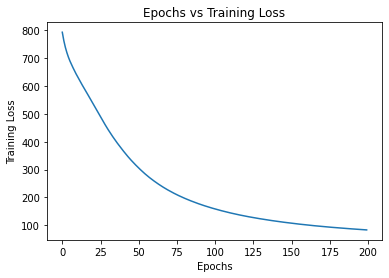

In [13]:
# Plot Loss vs Epoches
plt.figure()
plt.plot(loss_history)
plt.title("Epochs vs Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.show()

### Evaluation on test data

Now we will be evaluating the accuracy we get from the trained model. We feed training data and test data to the forward model along with the trained parameters. 

Note that, we need to covert the output probability of the forward pass to binary labels before evaluating accuracy. Since the model provides the posterior probability $p(y = 1 | x)$ in range [0,1]. We can binarize them using 0.5 as a theshold (i.e. if $y_i^{(2)}\geq 0.5$, $y_i^{(2)} \gets 1$ otherwise  $y_i^{(2)} \gets 0$).

In [14]:
# TRAINING ACCURACY
correct = 0
correctTrainingIndexes = np.zeros(0)
wrongTrainingIndexes = np.zeros(0)

# Get correct/wrong indexes for training class 1
for i in range(np.sum(Y2 < 0.5)):
    if(Y_true[np.where(Y2 < 0.5)[0][i]] == 0):
        correct += 1
        correctTrainingIndexes = np.append(correctTrainingIndexes, np.where(Y2 < 0.5)[0][i])
    else:
        wrongTrainingIndexes = np.append(wrongTrainingIndexes, np.where(Y2 < 0.5)[0][i])

# Get correct/wrong indexes for training class 2
for i in range(np.sum(Y2 >= 0.5)):
    if(Y_true[np.where(Y2 >= 0.5)[0][i]] == 1):
        correct += 1
        correctTrainingIndexes = np.append(correctTrainingIndexes, np.where(Y2 >= 0.5)[0][i])
    else:
        wrongTrainingIndexes = np.append(wrongTrainingIndexes, np.where(Y2 >= 0.5)[0][i])

# Compute and print training accuracy
trainingAccuracy = (correct/Y2.size) * 100
print("Training accuracy:", str(trainingAccuracy), "%")

# TEST ACCURACY
correct = 0
correctTestIndexes = np.zeros(0)
wrongTestIndexes = np.zeros(0)

# Use optimized parameters on a forward pass of the test data set
Y2_test = forward(test_x, params)[0]

# Get correct/wrong indexes for test class 1
for i in range(np.sum(Y2_test < 0.5)):
    if(Y_true[np.where(Y2_test < 0.5)[0][i]] == 0):
        correct += 1
        correctTestIndexes = np.append(correctTestIndexes, np.where(Y2 < 0.5)[0][i])
    else:
        wrongTestIndexes = np.append(wrongTestIndexes, np.where(Y2 < 0.5)[0][i])

# Get correct/wrong indexes for test class 2
for i in range(np.sum(Y2_test >= 0.5)):
    if(Y_true[np.where(Y2_test >= 0.5)[0][i]] == 1):
        correct += 1
        correctTestIndexes = np.append(correctTestIndexes, np.where(Y2 >= 0.5)[0][i])
    else:
        wrongTestIndexes = np.append(wrongTestIndexes, np.where(Y2 >= 0.5)[0][i])

# Change indexes to type numpy.int64
correctTrainingIndexes = correctTrainingIndexes.astype(np.int64)
wrongTrainingIndexes = wrongTrainingIndexes.astype(np.int64)
correctTestIndexes = correctTestIndexes.astype(np.int64)
wrongTestIndexes = wrongTestIndexes.astype(np.int64)

# Compute and print test accuracy
testAccuracy = (correct/Y2_test.size) * 100
print("Test accuracy:", str(testAccuracy), "%")

Training accuracy: 98.25 %
Test accuracy: 89.92497320471597 %


### Visualize some of the correct/miscalassified images

Now we will look at some images from training and test sets that were misclassified. 

Training set. 
Pick 5 images from each class that are correcly and incorreclty classified. 
True/False Positive/Negatives

Test set. 
Pick 5 images from each class that are correcly and incorreclty classified. 
True/False Positive/Negatives


Five correctly classified images from training set


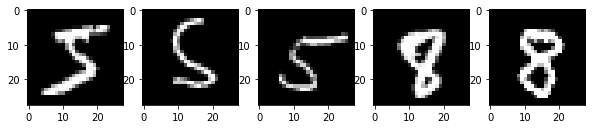

Five wrongly classified images from training set


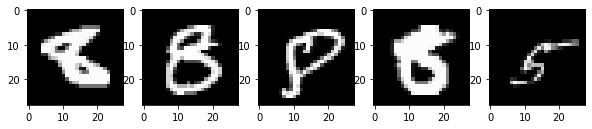

In [15]:
# Plot five correctly & wrongly classified images from the training set
newTrain_x = train_x.reshape(28, 28, train_x.shape[1])

print("Five correctly classified images from training set")
n_img = 5
plt.figure(figsize = (n_img * 2, 2))
plt.gray()
for i in range(n_img):
    plt.subplot(1, n_img, i + 1)
    plt.imshow(newTrain_x[:, :, correctTrainingIndexes[int((correctTrainingIndexes.size * i)/n_img)]])
plt.show()

print("Five wrongly classified images from training set")
n_img = 5
plt.figure(figsize = (n_img * 2, 2))
plt.gray()
for i in range(n_img):
    plt.subplot(1, n_img, i + 1)
    plt.imshow(newTrain_x[:, :, int(wrongTrainingIndexes[int((wrongTrainingIndexes.size * i)/n_img)])])
plt.show()

Five correctly classified images from test set


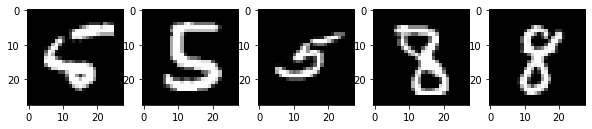

Five wrongly classified images from test set


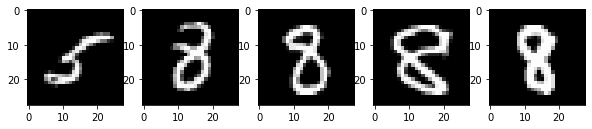

In [16]:
# Plot five correctly & wrongly classified images from the test set
newTest_x = test_x.reshape(28, 28, test_x.shape[1])

print("Five correctly classified images from test set")
n_img = 5
plt.figure(figsize = (n_img * 2, 2))
plt.gray()
for i in range(n_img):
    plt.subplot(1, n_img, i + 1)
    plt.imshow(newTest_x[:, :, correctTestIndexes[int((correctTestIndexes.size * i)/n_img)]])
plt.show()

print("Five wrongly classified images from test set")
n_img = 5
plt.figure(figsize = (n_img * 2, 2))
plt.gray()
for i in range(n_img):
    plt.subplot(1, n_img, i + 1)
    plt.imshow(newTest_x[:, :, int(wrongTestIndexes[int((wrongTestIndexes.size * i)/n_img)])])
plt.show()
 



---



## Question 2. Multiclass classification
Now we will build a classifier to separate all the digits. For this purpose, we will only change the last layer and the loss. 


Instead of using a single output, we will provide 10 outputs; and instead of using a binary cross entropy loss, we will use mutli-class cross entropy loss. 

In multinomal logistic regression (aka softmax regression), we define the posterior probability of label $y \in \{0,\ldots, K-1\}$ as 


$$p(y = c | \mathbf{x}) = \frac{\exp(\mathbf{w}_c^T\mathbf{x})}{\sum_{k=1}^K \exp(\mathbf{w}_k^T\mathbf{x})} = \mathbf{p}_c.$$ 

In other words, last layer of the network provides a probability vector $\mathbf{p} \in \mathbb{R}^K$, such that each $0 \le \mathbf{p}_c \le 1$ and $\sum_c \mathbf{p}_c = 1$. 

### Softmax function

Let us first define the softmax function, which is a multinomal extension of the sigmoid function that maps a vector of length $K$ to a probability vector. 

We can define ```softmax``` function on a vector $\mathbf{z} \in \mathbb{R}^K$ as $\mathbf{p} = \text{softmax}(\mathbf{z})$: 

$$\mathbf{p}_c(\mathbf{z}) = \frac{\exp(\mathbf{z}_c)}{\sum_{k=1}^K \exp(\mathbf{z}_k)}$$



In [17]:
def softmax(probs):
    # probs -- K x N numpy.ndarray, K is the number of classes, N is the number of samples
    probs = np.exp(probs)/np.sum(np.exp(probs), axis = 0)
    return probs

We have to note that the numerical range of floating point numbers in numpy is limited. For `float64` the upper bound is $10^{308}$. For exponential, its not difficult to overshoot that limit, in which case python returns `nan`.

To make our softmax function numerically stable, we simply normalize the values in the vector, by multiplying the numerator and denominator with a constant `C` as

\begin{align*}
\mathbf{p}_c  &= \frac{\exp(\mathbf{z}_c)}{\sum_{k=1}^K \exp(\mathbf{z}_k)} \\
& = \frac{C\exp(\mathbf{z}_c)}{C\sum_{k=1}^K \exp(\mathbf{z}_k)}\\
& = \frac{\exp(\mathbf{z}_c + \log C)}{C\sum_{k=1}^K \exp(\mathbf{z}_k + \log C)}.
\end{align*}

We can choose an arbitrary value for `log(C)` term, but generally `log(C) = −max(z)` is chosen


In [18]:
def stable_softmax(probs): 
    # probs -- K x N numpy.ndarray, K is the number of classes, N is the number of samples
    probs = np.exp(probs - np.max(probs)) / np.sum(np.exp(probs - np.max(probs)), axis = 0)
    return probs

### Derivative of the softmax function

We can show that the derivative of the __softmax__ function with respect to any input can be written as 

$$ \frac{\partial \mathbf{p}_i}{\partial \mathbf{z}_j} = \begin{cases} \mathbf{p}_i(1-\mathbf{p}_j) & i = j \\ \mathbf{p}_i (-\mathbf{p}_j) & i \ne j. \end{cases}$$

[More info here](https://deepnotes.io/softmax-crossentropy)


### Multiclass cross entropy loss function

We will minimize the cross entropy loss. You will use the true labels and predicted labels of a batch of N samples. 

The multi-class cross entropy loss for $i^{th}$ sample can be written as 
$$Loss_i = -\sum_c \mathbf{1}(y_i = c) \log \mathbf{p}_c $$
where $y_i$ is the true label and 

$$\mathbf{1}(y_i = c) = \begin{cases} 1 & y_i =c \\ 0 & \text{otherwise} \end{cases}$$ 
is an indicator function. 

We can find the average loss for a batch of N samples as $Loss=\frac{1}{N}\sum_{i=1}^{N} Loss_i$. 


In [19]:
def MultiClassCrossEntropyLoss(Y_true, probs):
  # probs -- K x N array
  # Y_true -- 1 x N array 
  # loss -- sum Loss_i over N samples 

  N = Y_true.shape[0] # N Samples
  p = stable_softmax(probs)
  log_likelihood = -np.log(p[Y_true.astype(int), range(N)])
  loss = np.sum(log_likelihood)/N
  return loss

### Derivative of the cross entropy loss 

Let us assume that $\mathbf{p} = \text{softmax}(\mathbf{z})$. 

Note that the derivative of the loss w.r.t. $\mathbf{p}_j$ can be written as 
$$\frac{\partial Loss_i }{\partial \mathbf{p}_j} = \begin{cases} -1/\mathbf{p}_j & j = y_i \\ 0 & j \ne y_i \end{cases}. $$

Note that we can use _total derivative_ to compute the derivative of the loss for $i$th sample w.r.t. $j$th entry in $\mathbf{z}$ as

\begin{align*}
\frac{\partial Loss_i}{\partial \mathbf{z}_j} = \sum_c \frac{\partial Loss_i}{\partial \mathbf{p}_c}\frac{\partial \mathbf{p}_c}{\partial \mathbf{z}_j}.
\end{align*}

From our discussion above, we know that the $\frac{\partial Loss_i}{\partial \mathbf{p}_c} = 0$ if $c \ne y_i$. 


\begin{align*}
\frac{\partial Loss_i}{\partial \mathbf{z}_j} &= -\frac{1}{\mathbf{p}_c} \frac{\partial \mathbf{p}_c}{\partial \mathbf{z}_j} \\
& = \begin{cases} \mathbf{p}_j - 1 & j = y_i \\ \mathbf{p}_j & j \ne y_i. \end{cases}
\end{align*}

Therefore, $$\delta^{(2)} = \nabla_{\mathbf{z}^{(2)}} Loss_i = \mathbf{p} - \mathbf{1}_{y_i}.$$

where $\mathbf{1}_{y_i}$ is a __one-hot vector__ that has length $K$ and is zero everywhere except 1 at index same as $y_i$. 


### Training data

Let us pick training data for multi-class classification. 

Pick same number of images from each class for training and create arrays for input and output. 

```
# train_x -- N x 784 array of training input
# train_y -- N x 1 array of labels 
```  

If you use 1000 images from each class N = 10000. You can increase the number of training samples if you like. You may also use unequal number of images in each class. 

We also need to transpose the dimension of the data so that their size becomes $784\times N$. It will be helpful to feed it to our model based on our notations.

In [20]:
# Pick training samples 
num_samples = 1000

def extractAllClassificationDataset(x, y, num_samples):
  # Make numpy arrays to store training data
  x_ = np.zeros((0, 784))
  y_ = np.zeros((0))

  # num_samples samples per label put in numpy arrays
  for label in range(10):
    tempX = x[y == label] # Array for 1 class
    tempX = tempX[:num_samples]
    tempY = np.full(num_samples, label) # Array of labels
    
    x_ = np.concatenate((x_, tempX), axis = 0)
    y_ = np.concatenate((y_, tempY), axis = 0)

  return x_.T, y_

# Training & test data
train_x, train_y = extractAllClassificationDataset(x_train, y_train, num_samples)
test_x, test_y = extractAllClassificationDataset(x_test, y_test, num_samples)

### Network Architecture

We will be using a two layer neural network in our experiment. The input layer has 784 nodes, the hidden layer will have 256 nodes and the output layer will have 10 nodes. First layer will have __sigmoid__ activation and second layer will have __softmax__ activation.

The equations for feedforward operation will be as follows.

$$\mathbf{z}^{(1)}=W^{(1)} \mathbf{x}+ \mathbf{b}^{(1)}\\\mathbf{y}^{(1)}=\text{sigmoid}(\mathbf{z}^{(1)})\\\mathbf{z}^{(2)}=W^{(2)}  \mathbf{y}^{(1)}+ \mathbf{b}^{(2)} \\\mathbf{p} = \mathbf{y}^{(2)}=\text{softmax}(\mathbf{z}^{(2)})$$

where $\mathbf{x}\in \mathbb{R}^{784}$ is the input layer, $\mathbf{y}^{(1)}\in \mathbb{R}^{256}$ is the hidden layer, $\mathbf{y}^{(2)} \in \mathbb{R}$ is the output layer, $W^{(1)}\in \mathbb{R}^{256\times 784}$ is the first layer weights, $W^{(2)}\in \mathbb{R}^{10\times 256}$ is the second layer weights, $\mathbf{b}^{(1)}\in \mathbb{R}^{256}$ is the first layer bias, $\mathbf{b}^{(2)}\in \mathbb{R}^{10}$ is the second layer bias vector.

### Network initialization

We initialize the weights for $W^{(1)}$ and $W^{(2)}$ with random values drawn from normal distribution with zero mean and 0.01 standard deviation. We will initialize bias vectors $\mathbf{b}^{(1)}$ and $\mathbf{b^{(2)}}$ with zero values. 

We can fix the seed for random initialization for reproducibility.

In [21]:
# Initialize Nueral Network
def TwoLayerNetwork(layer_dims=[784, 256, 10]):
    # Fix the seed
    np.random.seed(3)

    # Initialize Normally Distributed Weights
    W1 = np.random.normal(0, 0.01, (layer_dims[1], layer_dims[0])) # (256, 784)
    W2 = np.random.normal(0, 0.01, (layer_dims[2], layer_dims[1])) # (10, 256)

    # Initialize Biases to 0
    b1 = np.zeros(layer_dims[1]) # (256, )
    b2 = np.zeros(layer_dims[2]) # (10, ))

    # Return array of weights/biases
    params = np.array([W1, b1, W2, b2], dtype=object)
    return params

### Forward propagation 
Next, we will write the code for the forward pass for two layer network. Each layer consists of an affine function (fully-connected layer) followed by an activation function. You wil also return the intermediate results ($\mathbf{x}, \mathbf{z}^{(1)}, \mathbf{y}^{(1)}, \mathbf{z}^{(2)}$) in addition to final output ($\mathbf{y}^{(2)}$). You will need the intermediate outputs for the backpropagation step.

In [22]:
# Forward Propagation Function
def forward(X, params):
    # Inputs:
      # X -- 784 x N array 
      # params
        # W1 -- 256 x 784 matrix
        # b1 -- 256 x 1 vector
        # W2 -- 10 x 256 matrix
        # b2 -- 10 x 1 vector 
      
    # Outputs:
      # probs -- 10 x N output

    Z1 = np.matmul(params[0], X) + params[1][:, np.newaxis] # W1X + b1
    Y1 = sigmoid(Z1) # Output of layer 1
    Z2 = np.matmul(params[2], Y1) + params[3][:, np.newaxis] # W2Y1 + b2
    probs = stable_softmax(Z2) # Final output

    # Put all intermediate values in array and return
    intermediate = np.array([X, Z1, Y1, Z2], dtype=object)
    return probs, intermediate

### Backpropagration step

Now we will implement the backpropagation step for the two layer neural network using softmax layer and loss function. 


You will need the gradient of the Loss w.r.t. $W^{(l)},\mathbf{b}^{(l)}$ for $l = 1,2$ for all the training samples.  

We saw that we can write the gradient of Loss with respect to $W^{(l)}, \mathbf{b}^{(l)}$ for a single sample as

$$\nabla_{W^{(l)}} Loss_i = \delta^{(l)} \mathbf{y}^{(l-1)T},$$  
$$\nabla_{\mathbf{b}^{(l)}} Loss_i = \delta^{(l)},$$


where 
$$\delta^{(l)} = \nabla_{\mathbf{z}^{(l)}} Loss = \nabla_{\mathbf{y}^{(l)}} Loss \odot \varphi'(\mathbf{z}^{(l)}).$$ 

We saw above that for an $i$th sample, $\delta^{(2)} = \nabla_{\mathbf{z}^{(2)}} Loss_i = \mathbf{p} - \mathbf{1}_{y_i},$ where $\mathbf{1}_{y_i}$ is a __one-hot vector__ that has length $K$ and is zero everywhere except 1 at index same as $y_i$ and $\mathbf{p}$ is the outpu probability vector for the $i$th sample. 


**Once we have the gradients $\nabla_{W^{(l)}} Loss_i, \nabla_{\mathbf{b}^{(l)}} Loss_i$ for all $i$. We can compute their average to compute the gradient of the total loss function as**

$$\nabla_{W^{(l)}} Loss = \frac{1}{N} \sum_i \nabla_{W^{(l)}} Loss_i, $$
$$ \nabla_{\mathbf{b}^{(l)}} Loss = \frac{1}{N} \sum_i  \nabla_{\mathbf{b}^{(l)}} Loss_i.$$

**Please refer to the slides and lectures for more details.**

In [23]:
# Backpropagation Function
def backward(Y_true, probs, intermediate, params):
    # Inputs: 
      # Y_true -- 1 x N true labels
      # probs -- 10 x N output of the last layer
      # intermediate -- X, Z1, Y1, Z2 
      # params -- W1, b1, W2, b2 
    
    # Outputs: 
      # grads -- [grad_W1, grad_b1, grad_W2, grad_b2]

    # Num Samples
    N = np.size(Y_true)

    # LAYER 2 (l = L)
    delta2 = np.zeros((10, N))
    Y1 = intermediate[2]

    # Compute delta2
    for i in range(N):
      oneHot = np.zeros(10)
      oneHot[Y_true[i].astype(int)] = 1
      delta2[:, i] = probs[:, i] - oneHot

    # Compute b2GradientAverage/W2GradientAverage
    b2GradientAverage = np.zeros((10))
    for j in range(10):
      b2GradientAverage[j] = np.average(delta2[j, :])
    W2GradientAverage = (1/N) * np.matmul(delta2, Y1.T) # (10, 256)

    # LAYER 1 (l < L)
    W2 = params[2]
    Z1 = intermediate[1]
    
    # Compute delta1
    delta1 = np.matmul(W2.T, delta2) * (sigmoid(Z1) * (1 - sigmoid(Z1))) # (256, 10000)

    # Compute b1GradientAverage
    b1GradientAverage = np.zeros((256))
    for j in range(256):
      b1GradientAverage[j] = np.average(delta1[j, :])

    # Compute W1GradientAverage
    X = intermediate[0]
    W1GradientAverage = (1/N) * np.matmul(delta1, X.T) # (256, 784)

    # Put weight/bias gradients in array and return
    grads = np.array([W1GradientAverage, b1GradientAverage, W2GradientAverage, b2GradientAverage], dtype=object)
    return grads

### Train the model
We will use the forward and backward functions defined above with the same optimizer defined in the previous question to train our multi-class classificaiton model. 

We will specify the number of nodes in the layers, number of epochs and learning rate and initialize the network

In [24]:
# Specify layer dimensions, number of epochs, and learning rate
layer_dims = [train_x.shape[0], 256, 10]
epochs = 500
lr = 0.02

# Initialize Neural Network
params = TwoLayerNetwork(layer_dims)

Then we train the network for the number of epochs specified above. In every epoch, we will do the following:
1. Calculate the forward pass to get estimated labels.
2. Use the estimated labels calculate loss. We will be recording loss for every epoch.
3. Use backpropagation to calculate gradients.
4. Use gradient descent to update the weights and biases.

You should store the loss value after every epoch in an array ```loss_history```  and print the loss value after every few epochs (say 20). 


In [25]:
# True labels (N x 1)
Y_true = train_y

# Calculate loss for each epoch
loss_history = np.zeros(epochs)
for i in range(epochs):
  # Forward Pass
  probs, intermediate = forward(train_x, params) # Y2 1 x N output, intermediate[X, Z1, Y1, Z2], params[W1, b1, W2, b2]

  # Backpropagation
  grads = backward(Y_true, probs, intermediate, params)

  # Gradient Descent Update
  params = GD(params, grads, lr)

  # Calculate Loss
  loss_history[i] = MultiClassCrossEntropyLoss(Y_true, probs)
  if i % 20 == 0: # Print every 20 losses
    print(loss_history[i])

2.3033047018204535
2.228557598118711
2.1195884853693467
2.0119619867878655
1.9232071841798817
1.854247416541552
1.8020129255461304
1.7623696760922638
1.7315581747499889
1.7071640542602389
1.6873931094291788
1.671076904596966
1.6573877897491527
1.6457116243548422
1.6356323697626722
1.626738713369389
1.618917815665574
1.611864370746986
1.605541817611243
1.599894625548676
1.594783825659189
1.5897779969626713
1.5859829268646817
1.5811754668141613
1.5782680925817567


Now we will plot the recorded loss values vs epochs. We will observe the training loss decreasing with the epochs.

<function matplotlib.pyplot.show(close=None, block=None)>

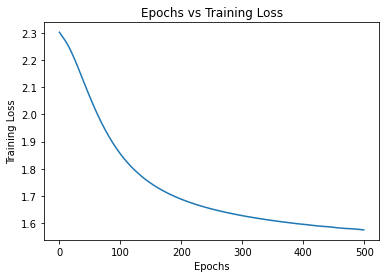

In [26]:
# Plot Loss vs Epoches
plt.figure()
plt.plot(loss_history)
plt.title("Epochs vs Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.show

### Evaluation on test data

Now we will be evaluating the accuracy we get from the trained model. We feed training data and test data to the forward model along with the trained parameters. 

Note that, we need to convert the (probability) output of the forward pass into labels before evaluating accuracy. We can assign label based on the maximum probability. 

We assign estimated labels $$\hat{y}_i = \arg \max_c  \mathbf{p}_c $$ for every probility vector. 

In [27]:
# TRAINING ACCURACY
N = probs.shape[1]
correct = 0
correctTrainingIndexes = np.zeros(0)
wrongTrainingIndexes = np.zeros(0)

for i in range(N):
    argmax = np.argmax(probs[:, i])
    if(argmax == Y_true[i]):
        correct += 1
        correctTrainingIndexes = np.append(correctTrainingIndexes, i)
    else:
        wrongTrainingIndexes = np.append(wrongTrainingIndexes, i)

# Compute and print training accuracy
trainingAccuracy = (correct/N) * 100
print("Training accuracy:", str(trainingAccuracy), "%")

# TEST ACCURACY
correct = 0
correctTestIndexes = np.zeros(0)
wrongTestIndexes = np.zeros(0)

# Use optimized parameters on a forward pass of the test data set
probs_test = forward(test_x, params)[0]
N = probs_test.shape[1]

for i in range(N):
    argmax = np.argmax(probs_test[:, i])
    if(argmax == Y_true[i]):
        correct += 1
        correctTestIndexes = np.append(correctTestIndexes, i)
    else:
        wrongTestIndexes = np.append(wrongTestIndexes, i)

# Compute and print test accuracy
testAccuracy = (correct/N) * 100
print("Test accuracy:", str(testAccuracy), "%")

# Change indexes to type numpy.int64
correctTrainingIndexes = correctTrainingIndexes.astype(np.int64)
wrongTrainingIndexes = wrongTrainingIndexes.astype(np.int64)
correctTestIndexes = correctTestIndexes.astype(np.int64)
wrongTestIndexes = wrongTestIndexes.astype(np.int64)

Training accuracy: 96.28 %
Test accuracy: 84.15082771305947 %


### Visualize some of the correct/miscalassified images [optional]

Now we will look at some images from training and test sets that were misclassified. 

Training set. 
Pick example from each class that are correcly and incorreclty classified. 
True/False Positive/Negatives

Test set. 
Pick examples from each class that are correcly and incorreclty classified. 
True/False Positive/Negatives


Five correctly classified images from training set


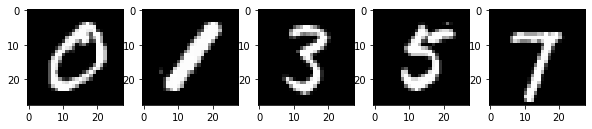

Five wrongly classified images from training set


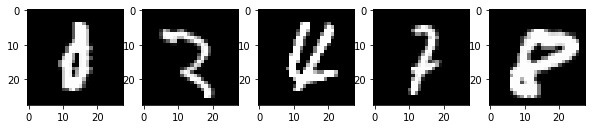

In [28]:
# Plot five correctly & wrongly classified images from the training set
newTrain_x = train_x.reshape(28, 28, train_x.shape[1])

print("Five correctly classified images from training set")
n_img = 5
plt.figure(figsize = (n_img * 2, 2))
plt.gray()
for i in range(n_img):
    plt.subplot(1, n_img, i + 1)
    plt.imshow(newTrain_x[:, :, correctTrainingIndexes[int((correctTrainingIndexes.size * i)/n_img)]])
plt.show()

print("Five wrongly classified images from training set")
n_img = 5
plt.figure(figsize = (n_img * 2, 2))
plt.gray()
for i in range(n_img):
    plt.subplot(1, n_img, i + 1)
    plt.imshow(newTrain_x[:, :, int(wrongTrainingIndexes[int((wrongTrainingIndexes.size * i)/n_img)])])
plt.show()

### Note about implementation

This is a note on two problems I have seen in the past and how they can be easily fixed. 

1. Summation along different axes ? 

2. Summation of gradients over samples ? 




**1. Summation to create probability vectors in the Softmax function**

Suppose X is a d x N array, in our case, it is 784 x 10000. 

`Z2 = W2 Y1 + b2  will be 10 x 10000 array `



`softmax(Z2)` will be a `10 x 10000` array in which we want to apply a softmax function on every column of `Z2` by first computing exponential and then normalizing the column to sum to 1, which is needed for it to be a probability vector. 




We can do that as 
```
probs = np.exp(Z2) 

# now you want to sum up each column and divide the column by the sum so that each column is a valid probability vector

probs /= np.sum(probs,axis=0,keepdims=True) # this makes sum of each column to 1
```

The **WRONG** thing to do is
```
probs /= np.sum(probs) 
# This is WRONG. np.sum() computes sum of the entire array. 
```



**2. Computing gradient for the entire loss function**

(this involves summation of N rank-one matrices in our notation.)




Suppose you have computed delta1, delta2 properly




Let's assume you computed
```
# delta2 is a 10 x 10000 array
# Y1 is a 256 x 10000 array
# N is 10000
# grad_W2 should be a 10 x 256 array
```



We can expand the formula for the gradient of the overall loss. 

$$\nabla_{W^{(2)}} Loss = \frac{1}{N}\sum_i \nabla_{W^{(2)}} Loss_i, $$ 

where 

$\nabla_{W^{(2)}} Loss_i = \delta^{(2)} y^{(1)T}$ is the gradient of the loss for $i^{th}$ training sample, where $\delta^{(2)}$ is a column of length 10 and $y^{(1)T}$ is a row of length 256, corresponding to $i^{th}$ training sample. Matrix product of column and row gives a a rank-1 matrix of size 10 x 256. 




To compute the gradient of loss over all the training samples, we need to average the rank-1 matrices for all N training samples.


We can write the code for that as 

```
# Sum gradient of loss for each sample
for i in range(N):
	grad_W2 += (1/N)*delta2[:,i,None].dot(Y1[:,i,None].T)

# OR we can compute grad_W2 without for loop as 
grad_W2 = 1/N*np.dot(delta2,Y1.T)
```

To see why this is true, you can convince yourself that matrix product of an `M x N` matrix with an `N x K` matrix can be written as a summation of N `M x K` rank-one matricess. 




Suppose 

$ A = [\mathbf{a}_1 ~ \cdots ~ \mathbf{a}_N] \text{ and } B  = \begin{bmatrix} \mathbf{b}_1^T \\ \vdots \\ \mathbf{b}_N^T \end{bmatrix}, $

where $\mathbf{a}_i, \mathbf{b}_i$ are columns of length $M, K$, respectively.  

 

We can write $AB$ as 




$$AB = \sum_{i = 1}^N \mathbf{a}_i \mathbf{b}_i^T.$$ 




 
